# A Survey of Venues in Honolulu, Hawaii

### AIM
The aim of this project is to explore the venues of Honolulu which is the capital of Hawaii and let people decide the restaurant that suits them based on their ratings and average price. This data is fetched using the Foursquare and the Zomato API and finally the data is combined to produce the desired results.

1. The required libraries are imported first

In [46]:
#The required libraries are first imported 
import numpy as np
import pandas as pd
import folium #for visualization of maps
import requests #for making API requests as well as for scrapping web data

In [47]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize

2. The coordinates of Honolulu are used here directly from Wikipedia. This can also be done using the geopy library.

In [48]:
#coordinates of Honolulu , the capital of Hawaii
Latitude = 21.315603
Longitude = -157.858093
print("The coordinates of Honolulu are {}, {}.".format(Latitude,Longitude))

The coordinates of Honolulu are 21.315603, -157.858093.


3. Folium library is used to display the zoomed map of Honolulu so that we can clearly visualize the areas where we will be expecting a plokt of results of the best suited restaurants.

In [49]:
#displaying Honolulu on a map
Honolulu_map =folium.Map(location = [Latitude,Longitude], zoom_start =13.8) # the zoom_start is set to 13.8 here , you can change and get anything according to your preferance
Honolulu_map.save("Honolulu_map.html")
Honolulu_map

4. Fetching data from the FOURSQUARE API: The clientID, clientSecret, radius (within which we want to fetch data of venues),number of venues and version(current date to fetch the latest data) are entered to carry out the rest of the functions

In [50]:
#foursquare API, radius , number of venues and version
ClientID = "BD0K4OU5410PHBDNPVMU5IM3PXR2430ZONMYK5E1MDFQISKX"
ClientSecret = "YEMVVZ4WSYEL2ZWJ5H3ED3M4DZZIILUHRQ3QIIZ4HZR3XYZI"
Radius = 2000  # 2km
VenuesNo = 50
Version = "20200421"  #current date

In [51]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
    if len(categories_list) ==0:
        return None
    else:
        return categories_list[0]['name']

In [52]:
pd.set_option("display.max_rows",None)
offset = 0
TotalVenues =0
FourSquare = pd.DataFrame(columns = ['name','categories','lat','long'])

The maximum number of free calls this API can make in a day are 100. The API is called again and again until all the venues within the given distance are fetched.  

In [53]:
# fetching venues using the Foursquare API
while(True):
    url = ("https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}").format(ClientID,ClientSecret,Version,Latitude,Longitude,Radius,VenuesNo,offset)
    result =requests.get(url).json()
    fetched_venues = len(result['response']['groups'][0]['items'])
    TotalVenues = TotalVenues + fetched_venues
    print("Total {} venues fetched within a total radiues of {} km".format(fetched_venues,Radius/1000))
    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)
    
    #filter the columns
    filtered_columns =['venue.name','venue.categories','venue.location.lat','venue.location.lng']
    venues =  venues.loc[:,filtered_columns]
    
    #filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis =1)
    
    #clean the column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    FourSquare = pd.concat([FourSquare,venues], axis =0)
    if(fetched_venues <50):
        break
    else:
        offset = offset +50
    FourSquare = FourSquare.reset_index(drop =True)
    print("\nTotal {} venues fetched".format(TotalVenues))

ConnectionError: HTTPSConnectionPool(host='api.foursquare.com', port=443): Max retries exceeded with url: /v2/venues/explore?client_id=BD0K4OU5410PHBDNPVMU5IM3PXR2430ZONMYK5E1MDFQISKX&client_secret=YEMVVZ4WSYEL2ZWJ5H3ED3M4DZZIILUHRQ3QIIZ4HZR3XYZI&v=20200421&ll=21.315603,-157.858093&radius=2000&limit=50&offset=0 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002A0F4F7E7C8>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

5. Fetching data using the ZOMATO API:  This requires a Zomato user key which can be accessed after creating a developer account. Then use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information

In [ ]:
#fetching venues using the Zomato API
headers = {'user-key':'934f305070f3eee8fe83559443c39133'}
venues_info = []

for index, row in FourSquare.iterrows():
    print("Data for the following venue is being fetched: {}".format(index+1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url,headers = headers).json()
    if(len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_info.append(venue)
    else:
        venues_info.append(np.zeros(6))
    
Zomato = pd.DataFrame(venues_info, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

6. DATA CLEANING: 
Data from various resources is combined properly

First the data fetched from the Foursquare API is displayed on the map.

In [12]:
#map of Honolulu showing venues marked by orange as provided by the Foursquare API
Honolulu_map = folium.Map(location = [Latitude,Longitude],zoom_start =12.50) 
for name,latitude,longitude in zip(FourSquare['name'],FourSquare['lat'],FourSquare['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [latitude, longitude],
    radius = 5,
    popup = label,
    color = 'orange',
    fill=True,
    fill_color = '#FFA500',
    fill_opacity =0.4,
    parse_html =False).add_to(Honolulu_map)
Honolulu_map.save("Venues by foursquare.html")   
Honolulu_map

From the data, we infer that the main clusters are around "The Arts District" , "Kaka'ako" and "Makiki Kai"

Now the data fetched from the Zomato API is displayed on a map

In [13]:
#map of Honolulu showing venues marked by dark magenta as provided by the Zomato API
Honolulu_map = folium.Map(location = [Latitude,Longitude],zoom_start =12.70) 
for venue,address,latitude,longitude in zip(Zomato['venue'],Zomato['address'],Zomato['latitude'],Zomato['longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [latitude, longitude],
    radius = 5,
    popup = label,
    color = 'darkmagenta',
    fill=True,
    fill_color = '#8B008B',
    fill_opacity = 0.5,
    parse_html =False).add_to(Honolulu_map)
Honolulu_map.save("Venues by zomato.html")       
Honolulu_map

From this map, we infer that the clusters are around "Chinatown" and "Kaka'ako"

7. Data from these two APIs are now combined

In [14]:
#combining the data from the two APIs into one dataframe
FourSquare['lat']= FourSquare['lat'].apply(lambda lat: round(float(lat),4))
FourSquare['lng']= FourSquare['lng'].apply(lambda lng: round(float(lng),4))
Zomato['latitude']= Zomato['latitude'].apply(lambda latitude: round(float(latitude),4))
Zomato['longitude']= Zomato['longitude'].apply(lambda longitude: round(float(longitude),4))

8. All unnecessary duplicates are dropped and the indices are reset

In [15]:
# data cleaning by resetting the index and dropping all the unnecessary duplicates
FourSquare.drop_duplicates(inplace=True)
Zomato.drop_duplicates(inplace=True)
FourSquare.reset_index(drop=True, inplace=True)
Zomato.reset_index(drop=True, inplace=True)

In [16]:
#using pandas to create a final dataframe
data_set = pd.concat([FourSquare,Zomato],axis = 1)
data_set['lat_diff'] = data_set['latitude'] - data_set['lat']
data_set['lng_diff'] = data_set['longitude'] - data_set['lng']

9. The final dataframe is obtained after cleaning

In [42]:
chosen_venues = data_set[(abs(data_set['lat_diff']) <= 0.01) & (abs(data_set['lng_diff'])<= 0.01)].reset_index(drop =True)
chosen_venues.head(5)

,name,categories,lat,long,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Royal Kitchen,Chinese Restaurant,21.3149,NaN,-157.8606,Royal Kitchen,21.3142,-157.8609,10.0,1.0,3.6,"100 N Beretania St, Honolulu 96817",-0.0007,-0.0003
1,JJ Dolan's,Pizza Place,21.3110,NaN,-157.8605,J.J. Dolan's,21.3110,-157.8605,25.0,2.0,4.1,"1147 Bethel Street, Honolulu 96813",0.0000,0.0000
2,Char Hung Sut,Chinese Restaurant,21.3124,NaN,-157.8619,Char Hung Sut,21.3125,-157.8618,10.0,1.0,3.8,"64 N Pauahi St, Honolulu 96817",0.0001,0.0001
3,Manifest,Lounge,21.3115,NaN,-157.8623,The Manifest,21.3116,-157.8621,10.0,1.0,3.1,"32 North Hotel Street, Honolulu 96817",0.0001,0.0002
4,Livestock Tavern,American Restaurant,21.3117,NaN,-157.8626,Livestock Tavern,21.3115,-157.8626,0.0,1.0,0,"49 N Hotel Street, Honolulu 96817",-0.0002,0.0000


We will inspect these venues based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

In [24]:
#calculation of the average price using the price for two column
chosen_venues['average_price'] = chosen_venues['price_for_two']/2
chosen_venues = chosen_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

CATEGORIES:

<BarContainer object of 39 artists>

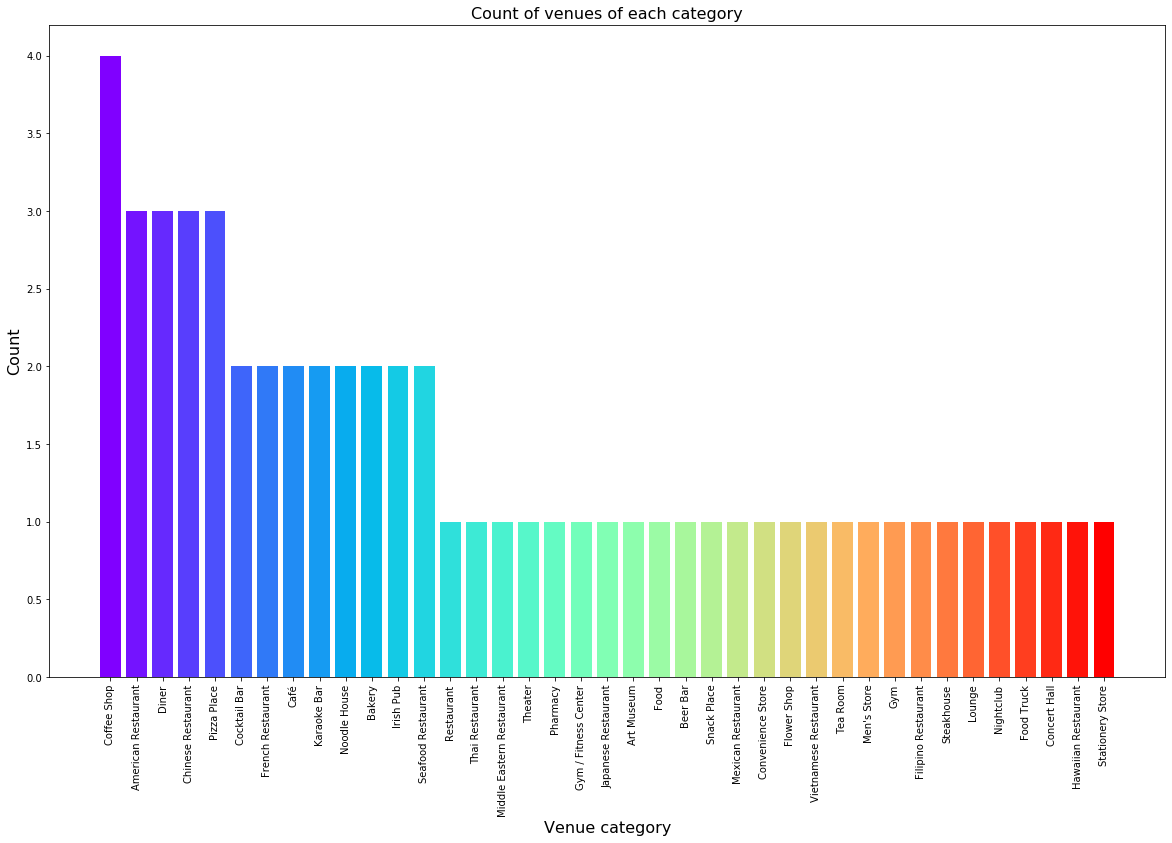

In [21]:
#Plotting a bar graph that shows that the count of coffe shops and pizz places is the highest
venue_distribution = chosen_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

A bar graph of Venue Category vs the Count of restaurants is made.
It is inferred that Coffe Shops are the major venues in Honolulu

RATINGS:

Text(0.5, 1.0, 'Count of venues with given rating')

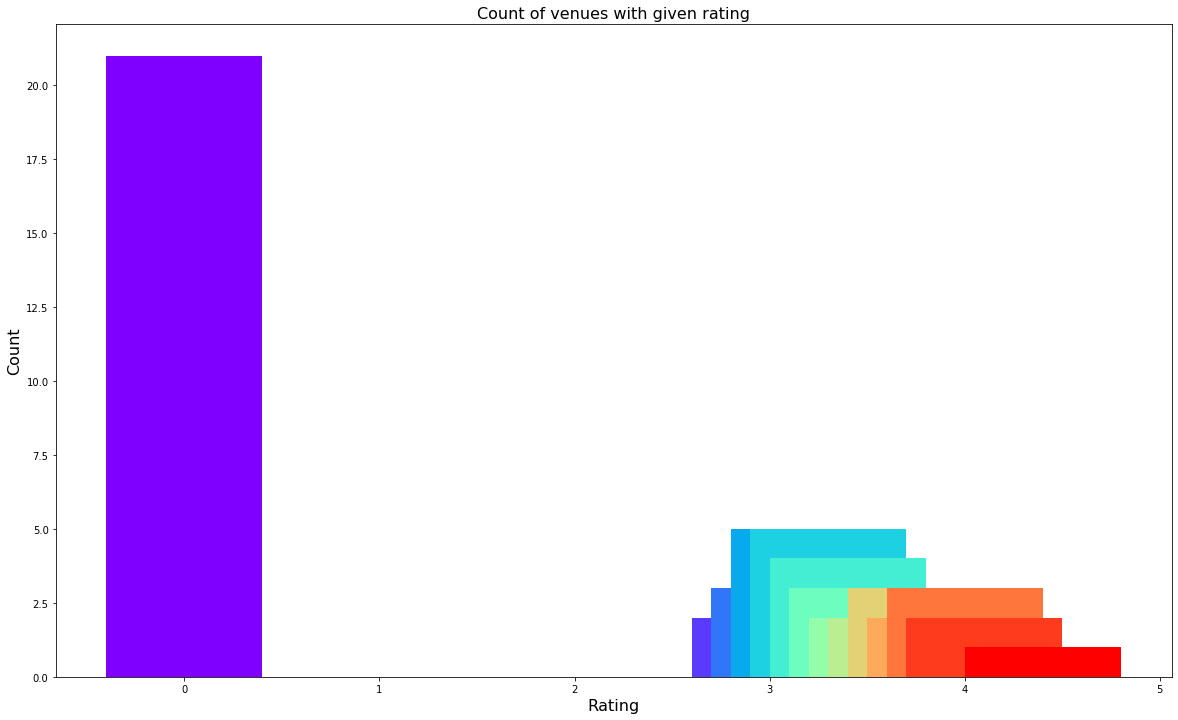

In [25]:
# a rating vs count plot of the fetched venues
chosen_venues['rating'] = chosen_venues['rating'].astype(float)
rating = chosen_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

Except the restaurants that haven't been rated, it can be seen that the majority of restaurants have a rating of 3.

In [28]:
bins = [1.0,2.0,3.0,5.0]
labels = ['Low','Mediocre','Good']
chosen_venues['rating_bin'] = pd.cut(chosen_venues['rating'].astype(float),bins = bins,labels= labels, include_lowest =True)

In [29]:
color_map = {'Low':'red','Mediocre':'yellow','Good':'green'}
Honolulu_map = folium.Map(location = [latitude,longitude],zoom_start = 12)
for name,address,latitude,longitude,rating_bin in zip(chosen_venues['venue'],chosen_venues['address'],chosen_venues['latitude'],chosen_venues['longitude'],chosen_venues['rating_bin']):
    label = '{}, {}'.format(name,address)
    label = folium.Popup(label, parse_html =True)
    folium.Marker([latitude,longitude],popup = label).add_to(Honolulu_map)
Honolulu_map.save("venues_ratings.html")
Honolulu_map

PRICE:

Text(0.5, 1.0, 'Count of venues with given average price')

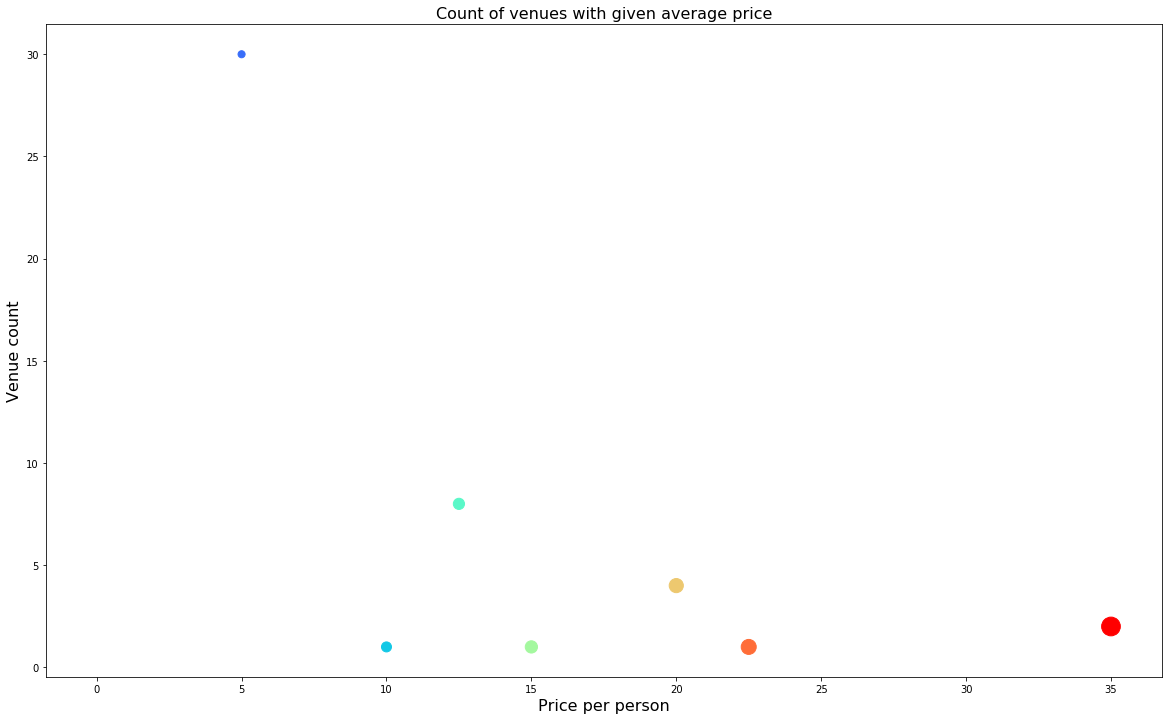

In [30]:
average_prices = chosen_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

10. CLUSTERING:

In [32]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = chosen_venues.drop(['venue', 'address', 'rating_bin', 'categories','long'],1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS,random_state =2)
kMeans.fit(clustering)
chosen_venues.insert(0, 'cluster_labels', kMeans.labels_)
chosen_venues.head(5)

,cluster_labels,categories,long,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Chinese Restaurant,NaN,Royal Kitchen,21.3142,-157.8609,1.0,3.6,"100 N Beretania St, Honolulu 96817",5.0,Good
1,0,Pizza Place,NaN,J.J. Dolan's,21.3110,-157.8605,2.0,4.1,"1147 Bethel Street, Honolulu 96813",12.5,Good
2,1,Chinese Restaurant,NaN,Char Hung Sut,21.3125,-157.8618,1.0,3.8,"64 N Pauahi St, Honolulu 96817",5.0,Good
3,1,Lounge,NaN,The Manifest,21.3116,-157.8621,1.0,3.1,"32 North Hotel Street, Honolulu 96817",5.0,Good
4,1,American Restaurant,NaN,Livestock Tavern,21.3115,-157.8626,1.0,0.0,"49 N Hotel Street, Honolulu 96817",0.0,NaN


In [45]:
Honolulu_map = folium.Map(location = [Latitude,Longitude], zoom_start = 13)
color_map = { 0: 'purple', 1: 'orange'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(chosen_venues['venue'], 
                                                        chosen_venues['address'], 
                                                        chosen_venues['cluster_labels'], 
                                                        chosen_venues['latitude'], 
                                                        chosen_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(Honolulu_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(Honolulu_map)

Honolulu_map.save("venues clusters.html")
Honolulu_map

KeyError: 'cluster_labels'

From the map we can clearly see the two clusters overlapping

In [44]:
result = chosen_venues[chosen_venues['cluster_labels'] == 0]
print("1st Cluster")
result.head(10).reset_index(drop = True)

KeyError: 'cluster_labels'

In [35]:
print("These venues for the first cluster have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for the first cluster have mean price range of 2.62 and rating spread around 2.96


In [36]:
result = chosen_venues[chosen_venues['cluster_labels'] == 1]
print("2nd Cluster")
result.head(10).reset_index(drop = True)

2nd Cluster


,cluster_labels,categories,long,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Chinese Restaurant,NaN,Royal Kitchen,21.3142,-157.8609,1.0,3.6,"100 N Beretania St, Honolulu 96817",5.0,Good
1,1,Chinese Restaurant,NaN,Char Hung Sut,21.3125,-157.8618,1.0,3.8,"64 N Pauahi St, Honolulu 96817",5.0,Good
2,1,Lounge,NaN,The Manifest,21.3116,-157.8621,1.0,3.1,"32 North Hotel Street, Honolulu 96817",5.0,Good
3,1,American Restaurant,NaN,Livestock Tavern,21.3115,-157.8626,1.0,0.0,"49 N Hotel Street, Honolulu 96817",0.0,NaN
4,1,French Restaurant,NaN,Hana Lunch Place,21.3097,-157.8603,1.0,0.0,"1117 Union Mall, Honolulu 96813",0.0,NaN
5,1,Thai Restaurant,NaN,Sing Cheong Yuan Bakery,21.3118,-157.8633,1.0,3.2,"1027 Maunakea St, Honolulu 96817",5.0,Good
6,1,Bakery,NaN,Fort Street Cafe,21.3108,-157.8602,1.0,3.9,"1152 Fort St Mall, Honolulu 96813",5.0,Good
7,1,Coffee Shop,NaN,Summer Frappe,21.3126,-157.8619,1.0,3.2,"82 N Pauahi St, Honolulu 96817",5.0,Good
8,1,Snack Place,NaN,Cafe Blue,21.3085,-157.8619,1.0,0.0,"111 S King St, 6th Floor, Honolulu 96813",0.0,NaN
9,1,Café,NaN,Le Crepe Cafe,21.3108,-157.8600,1.0,0.0,"1160 Fort St Mall, Honolulu 96813",5.0,NaN


In [37]:
print("These venues for the second cluster have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for the second cluster have mean price range of 1.02 and rating spread around 1.98
